In [1]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
    nn.Conv2d(oc, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
    nn.Conv2d(oc, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
)

blku = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
    nn.Conv2d(oc, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
    nn.Conv2d(oc, oc, 5, padding=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(oc, oc, 2, stride=2),
    nn.GroupNorm(oc // 8, oc),
    nn.LeakyReLU(),
)


class DummyX0Model(nn.Module):

    def __init__(self, n_channel: int, N: int = 16) -> None:
        super(DummyX0Model, self).__init__()
        self.down1 = blk(n_channel, 16)
        self.down2 = blk(16, 32)
        self.down3 = blk(32, 64)
        self.down4 = blk(64, 512)
        self.down5 = blk(512, 512)
        self.up1 = blku(512, 512)
        self.up2 = blku(512 + 512, 64)
        self.up3 = blku(64, 32)
        self.up4 = blku(32, 16)
        self.convlast = blk(16, 16)
        self.final = nn.Conv2d(16, N * n_channel, 1, bias=False)

        self.tr1 = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.tr2 = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.tr3 = nn.TransformerEncoderLayer(d_model=64, nhead=8)

        self.cond_embedding_1 = nn.Embedding(10, 16)
        self.cond_embedding_2 = nn.Embedding(10, 32)
        self.cond_embedding_3 = nn.Embedding(10, 64)
        self.cond_embedding_4 = nn.Embedding(10, 512)
        self.cond_embedding_5 = nn.Embedding(10, 512)
        self.cond_embedding_6 = nn.Embedding(10, 64)

        self.temb_1 = nn.Linear(32, 16)
        self.temb_2 = nn.Linear(32, 32)
        self.temb_3 = nn.Linear(32, 64)
        self.temb_4 = nn.Linear(32, 512)
        self.N = N

    def forward(self, x, t, cond) -> torch.Tensor:
        x = (2 * x.float() / self.N) - 1.0
        t = t.float().reshape(-1, 1) / 1000
        t_features = [torch.sin(t * 3.1415 * 2**i) for i in range(16)] + [
            torch.cos(t * 3.1415 * 2**i) for i in range(16)
        ]
        tx = torch.cat(t_features, dim=1).to(x.device)

        t_emb_1 = self.temb_1(tx).unsqueeze(-1).unsqueeze(-1)
        t_emb_2 = self.temb_2(tx).unsqueeze(-1).unsqueeze(-1)
        t_emb_3 = self.temb_3(tx).unsqueeze(-1).unsqueeze(-1)
        t_emb_4 = self.temb_4(tx).unsqueeze(-1).unsqueeze(-1)

        cond_emb_1 = self.cond_embedding_1(cond).unsqueeze(-1).unsqueeze(-1)
        cond_emb_2 = self.cond_embedding_2(cond).unsqueeze(-1).unsqueeze(-1)
        cond_emb_3 = self.cond_embedding_3(cond).unsqueeze(-1).unsqueeze(-1)
        cond_emb_4 = self.cond_embedding_4(cond).unsqueeze(-1).unsqueeze(-1)
        cond_emb_5 = self.cond_embedding_5(cond).unsqueeze(-1).unsqueeze(-1)
        cond_emb_6 = self.cond_embedding_6(cond).unsqueeze(-1).unsqueeze(-1)

        x1 = self.down1(x) + t_emb_1 + cond_emb_1
        x2 = self.down2(nn.functional.avg_pool2d(x1, 2)) + t_emb_2 + cond_emb_2
        x3 = self.down3(nn.functional.avg_pool2d(x2, 2)) + t_emb_3 + cond_emb_3
        x4 = self.down4(nn.functional.avg_pool2d(x3, 2)) + t_emb_4 + cond_emb_4
        x5 = self.down5(nn.functional.avg_pool2d(x4, 2))

        x5 = (
            self.tr1(x5.reshape(x5.shape[0], x5.shape[1], -1).transpose(1, 2))
            .transpose(1, 2)
            .reshape(x5.shape)
        )

        y = self.up1(x5) + cond_emb_5

        y = (
            self.tr2(y.reshape(y.shape[0], y.shape[1], -1).transpose(1, 2))
            .transpose(1, 2)
            .reshape(y.shape)
        )

        y = self.up2(torch.cat([x4, y], dim=1)) + cond_emb_6

        y = (
            self.tr3(y.reshape(y.shape[0], y.shape[1], -1).transpose(1, 2))
            .transpose(1, 2)
            .reshape(y.shape)
        )
        y = self.up3(y)
        y = self.up4(y)
        y = self.convlast(y)
        y = self.final(y)

        # reshape to B, C, H, W, N
        y = (
            y.reshape(y.shape[0], -1, self.N, *x.shape[2:])
            .transpose(2, -1)
            .contiguous()
        )

        return y


class D3PM(nn.Module):
    def __init__(
        self,
        x0_model: nn.Module,
        n_T: int,
        num_classes: int = 10,
        forward_type="uniform",
        hybrid_loss_coeff=0.001,
    ) -> None:
        super(D3PM, self).__init__()
        self.x0_model = x0_model

        self.n_T = n_T
        self.hybrid_loss_coeff = hybrid_loss_coeff

        steps = torch.arange(n_T + 1, dtype=torch.float64) / n_T
        alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
        self.beta_t = torch.minimum(
            1 - alpha_bar[1:] / alpha_bar[:-1], torch.ones_like(alpha_bar[1:]) * 0.999
        )

        # self.beta_t = [1 / (self.n_T - t + 1) for t in range(1, self.n_T + 1)]
        self.eps = 1e-6
        self.num_classses = num_classes
        q_onestep_mats = []
        q_mats = []  # these are cumulative

        for beta in self.beta_t:

            if forward_type == "uniform":
                mat = torch.ones(num_classes, num_classes) * beta / num_classes
                mat.diagonal().fill_(1 - (num_classes - 1) * beta / num_classes)
                q_onestep_mats.append(mat)
            else:
                raise NotImplementedError
        q_one_step_mats = torch.stack(q_onestep_mats, dim=0)

        q_one_step_transposed = q_one_step_mats.transpose(
            1, 2
        )  # this will be used for q_posterior_logits

        q_mat_t = q_onestep_mats[0]
        q_mats = [q_mat_t]
        for idx in range(1, self.n_T):
            q_mat_t = q_mat_t @ q_onestep_mats[idx]
            q_mats.append(q_mat_t)
        q_mats = torch.stack(q_mats, dim=0)
        self.logit_type = "logit"

        # register
        self.register_buffer("q_one_step_transposed", q_one_step_transposed)
        self.register_buffer("q_mats", q_mats)

        assert self.q_mats.shape == (
            self.n_T,
            num_classes,
            num_classes,
        ), self.q_mats.shape

    def _at(self, a, t, x):
        # t is 1-d, x is integer value of 0 to num_classes - 1
        bs = t.shape[0]
        t = t.reshape((bs, *[1] * (x.dim() - 1)))
        # out[i, j, k, l, m] = a[t[i, j, k, l], x[i, j, k, l], m]
        return a[t - 1, x, :]

    def q_posterior_logits(self, x_0, x_t, t):
        # if t == 1, this means we return the L_0 loss, so directly try to x_0 logits.
        # otherwise, we return the L_{t-1} loss.
        # Also, we never have t == 0.

        # if x_0 is integer, we convert it to one-hot.
        if x_0.dtype == torch.int64 or x_0.dtype == torch.int32:
            x_0_logits = torch.log(
                torch.nn.functional.one_hot(x_0, self.num_classses) + self.eps
            )
        else:
            x_0_logits = x_0.clone()

        assert x_0_logits.shape == x_t.shape + (self.num_classses,), print(
            f"x_0_logits.shape: {x_0_logits.shape}, x_t.shape: {x_t.shape}"
        )

        # Here, we caclulate equation (3) of the paper. Note that the x_0 Q_t x_t^T is a normalizing constant, so we don't deal with that.

        # fact1 is "guess of x_{t-1}" from x_t
        # fact2 is "guess of x_{t-1}" from x_0

        fact1 = self._at(self.q_one_step_transposed, t, x_t)

        softmaxed = torch.softmax(x_0_logits, dim=-1)  # bs, ..., num_classes
        qmats2 = self.q_mats[t - 2].to(dtype=softmaxed.dtype)
        # bs, num_classes, num_classes
        fact2 = torch.einsum("b...c,bcd->b...d", softmaxed, qmats2)

        out = torch.log(fact1 + self.eps) + torch.log(fact2 + self.eps)

        t_broadcast = t.reshape((t.shape[0], *[1] * (x_t.dim())))

        bc = torch.where(t_broadcast == 1, x_0_logits, out)

        return bc

    def vb(self, dist1, dist2):

        # flatten dist1 and dist2
        dist1 = dist1.flatten(start_dim=0, end_dim=-2)
        dist2 = dist2.flatten(start_dim=0, end_dim=-2)

        out = torch.softmax(dist1 + self.eps, dim=-1) * (
            torch.log_softmax(dist1 + self.eps, dim=-1)
            - torch.log_softmax(dist2 + self.eps, dim=-1)
        )
        return out.sum(dim=-1).mean()

    def q_sample(self, x_0, t, noise):
        # forward process, x_0 is the clean input.
        logits = torch.log(self._at(self.q_mats, t, x_0) + self.eps)
        noise = torch.clip(noise, self.eps, 1.0)
        gumbel_noise = -torch.log(-torch.log(noise))
        return torch.argmax(logits + gumbel_noise, dim=-1)

    def model_predict(self, x_0, t, cond):
        # this part exists because in general, manipulation of logits from model's logit
        # so they are in form of x_0's logit might be independent to model choice.
        # for example, you can convert 2 * N channel output of model output to logit via get_logits_from_logistic_pars
        # they introduce at appendix A.8.

        predicted_x0_logits = self.x0_model(x_0, t, cond)

        return predicted_x0_logits

    def forward(self, x: torch.Tensor, cond: torch.Tensor = None) -> torch.Tensor:
        """
        Makes forward diffusion x_t from x_0, and tries to guess x_0 value from x_t using x0_model.
        x is one-hot of dim (bs, ...), with int values of 0 to num_classes - 1
        """
        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        x_t = self.q_sample(
            x, t, torch.rand((*x.shape, self.num_classses), device=x.device)
        )
        # x_t is same shape as x
        assert x_t.shape == x.shape, print(
            f"x_t.shape: {x_t.shape}, x.shape: {x.shape}"
        )
        # we use hybrid loss.

        predicted_x0_logits = self.model_predict(x_t, t, cond)

        # based on this, we first do vb loss.
        true_q_posterior_logits = self.q_posterior_logits(x, x_t, t)
        pred_q_posterior_logits = self.q_posterior_logits(predicted_x0_logits, x_t, t)

        vb_loss = self.vb(true_q_posterior_logits, pred_q_posterior_logits)

        predicted_x0_logits = predicted_x0_logits.flatten(start_dim=0, end_dim=-2)
        x = x.flatten(start_dim=0, end_dim=-1)

        ce_loss = torch.nn.CrossEntropyLoss()(predicted_x0_logits, x)

        return vb_loss * self.hybrid_loss_coeff + ce_loss, {
            "vb_loss": vb_loss.detach().item(),
            "ce_loss": ce_loss.detach().item(),
        }

    def p_sample(self, x, t, cond, noise):

        predicted_x0_logits = self.model_predict(x, t, cond)
        pred_q_posterior_logits = self.q_posterior_logits(predicted_x0_logits, x, t)

        noise = torch.clip(noise, self.eps, 1.0)

        not_first_step = (t != 1).float().reshape((x.shape[0], *[1] * (x.dim())))

        gumbel_noise = -torch.log(-torch.log(noise))
        sample = torch.argmax(
            pred_q_posterior_logits + gumbel_noise * not_first_step, dim=-1
        )
        return sample

    def sample(self, x, cond=None):
        for t in reversed(range(1, self.n_T)):
            t = torch.tensor([t] * x.shape[0], device=x.device)
            x = self.p_sample(
                x, t, cond, torch.rand((*x.shape, self.num_classses), device=x.device)
            )

        return x

    def sample_with_image_sequence(self, x, cond=None, stride=10):
        steps = 0
        images = []
        for t in reversed(range(1, self.n_T)):
            t = torch.tensor([t] * x.shape[0], device=x.device)
            x = self.p_sample(
                x, t, cond, torch.rand((*x.shape, self.num_classses), device=x.device)
            )
            steps += 1
            if steps % stride == 0:
                images.append(x)

        # if last step is not divisible by stride, we add the last image.
        if steps % stride != 0:
            images.append(x)

        return images

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class IsingDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)
        
        self.images = (data['data']+1)/2
        
        mapping = {
            np.float64(0.0): 0,
            np.float64(0.2): 1,
            np.float64(0.4): 2,
            np.float64(0.6000000000000001): 3,
            np.float64(0.8): 4,
            np.float64(1.0): 5,
            np.float64(1.2000000000000002): 6,
            np.float64(1.4000000000000001): 7,
            np.float64(1.6): 8,
            np.float64(1.8): 9
        }
        
        # Convert float labels to integer labels using the mapping
        self.labels = np.vectorize(mapping.get)(data['labels'])
        self.transform = transform
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).unsqueeze(0)
        label = self.labels[idx]
        return image, label

# DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
    # Add other transformations if necessary
])

dataset = IsingDataset('ising_dataset_2.npz', transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

In [4]:
device = "cuda:1"

In [5]:
N = 2  # number of classes for discretized state per pixel
d3pm = D3PM(DummyX0Model(1, N), 1000, num_classes=N, hybrid_loss_coeff=0.0).to(device)
print(f"Total Param Count: {sum([p.numel() for p in d3pm.x0_model.parameters()])}")

optim = torch.optim.AdamW(d3pm.x0_model.parameters(), lr=1e-3)
d3pm.train()

n_epoch = 1500


Total Param Count: 63278080


In [6]:

# dataset = MNIST(
#     "./data",
#     train=True,
#     download=True,
#     transform=transforms.Compose(
#         [
#             transforms.ToTensor(),
#             transforms.Pad(2),
#         ]
#     ),
# )
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)



In [7]:
for k, l in dataloader:
    break

In [8]:
import matplotlib.pyplot as plt

In [12]:
l

tensor([0, 7, 6, 4, 9, 6, 7, 3, 6, 0, 8, 9, 1, 0, 6, 0, 3, 8, 6, 4, 6, 7, 9, 7,
        2, 0, 3, 4, 9, 2, 0, 8, 5, 2, 4, 4, 9, 2, 8, 5, 6, 5, 7, 3, 3, 1, 7, 2,
        0, 1, 2, 4, 1, 0, 1, 7, 5, 6, 3, 8, 3, 8, 4, 3, 9, 4, 7, 8, 4, 4, 9, 9,
        0, 1, 7, 3, 2, 4, 9, 7, 8, 9, 0, 3, 0, 5, 2, 6, 2, 9, 6, 6, 7, 9, 9, 8,
        1, 7, 4, 3, 4, 0, 5, 2, 5, 8, 0, 3, 2, 6, 7, 7, 6, 0, 2, 8, 2, 5, 6, 3,
        4, 3, 1, 8, 3, 4, 7, 8, 4, 3, 7, 3, 8, 7, 3, 4, 9, 5, 2, 2, 8, 0, 4, 4,
        9, 2, 4, 9, 0, 0, 9, 9, 0, 5, 0, 1, 8, 2, 9, 9, 4, 5, 9, 5, 1, 7, 6, 0,
        1, 5, 4, 5, 6, 0, 0, 5, 1, 4, 5, 6, 8, 5, 9, 7, 6, 4, 5, 8, 6, 8, 0, 5,
        3, 2, 5, 5, 2, 8, 1, 3, 2, 0, 5, 9, 0, 9, 3, 5, 6, 7, 9, 6, 0, 2, 4, 7,
        5, 5, 5, 7, 8, 8, 7, 3, 8, 7, 9, 6, 2, 8, 0, 1, 6, 0, 4, 8, 1, 4, 6, 2,
        6, 4, 5, 6, 8, 8, 7, 5, 3, 4, 6, 0, 3, 4, 4, 2])

(tensor(0.),
 tensor(1.),
 tensor(9),
 tensor(0),
 tensor(7))

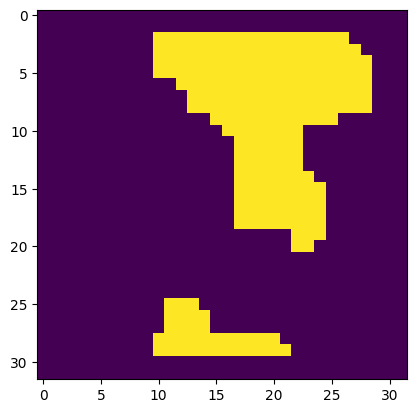

In [16]:
k[7].min(), k[10].max(), plt.imshow(k[1][0]), l.max(), l.min(), l[1]

In [17]:
dir_ =  'contents_ising'

In [ ]:
global_step = 0
for i in range(n_epoch):

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, cond in pbar:
        optim.zero_grad()
        x = x.to(device)
        cond = cond.to(device)

        # discritize x to N bins
        x = (x * (N - 1)).round().long().clamp(0, N - 1)
        loss, info = d3pm(x, cond)

        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(d3pm.x0_model.parameters(), 0.1)

        with torch.no_grad():
            param_norm = sum([torch.norm(p) for p in d3pm.x0_model.parameters()])

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.99 * loss_ema + 0.01 * loss.item()
        pbar.set_description(
            f"loss: {loss_ema:.4f}, norm: {norm:.4f}, param_norm: {param_norm:.4f}, vb_loss: {info['vb_loss']:.4f}, ce_loss: {info['ce_loss']:.4f}"
        )
        optim.step()
        global_step += 1

        if global_step % 300 == 1:
            d3pm.eval()

            with torch.no_grad():
                cond = torch.arange(0, 4).to(device) % 10
                init_noise = torch.randint(0, N, (4, 1, 32, 32)).to(device)

                images = d3pm.sample_with_image_sequence(
                    init_noise, cond, stride=40
                )
                # image sequences to gif
                gif = []
                for image in images:
                    x_as_image = make_grid(image.float() / (N - 1), nrow=2)
                    img = x_as_image.permute(1, 2, 0).cpu().numpy()
                    img = (img * 255).astype(np.uint8)
                    gif.append(Image.fromarray(img))

                gif[0].save(
                    f"{dir_}/sample_{global_step}.gif",
                    save_all=True,
                    append_images=gif[1:],
                    duration=100,
                    loop=0,
                )

                last_img = gif[-1]
                last_img.save(f"{dir_}/sample_{global_step}_last.png")

            d3pm.train()


loss: 0.5491, norm: 0.0022, param_norm: 1191.2866, vb_loss: 0.0060, ce_loss: 0.5308: 100%|██████████| 235/235 [00:24<00:00,  9.76it/s]
loss: 0.5307, norm: 0.0013, param_norm: 1188.7089, vb_loss: 0.0006, ce_loss: 0.5308: 100%|██████████| 235/235 [00:19<00:00, 11.83it/s]
loss: 0.5307, norm: 0.0036, param_norm: 1186.0629, vb_loss: 0.0005, ce_loss: 0.5308: 100%|██████████| 235/235 [00:20<00:00, 11.75it/s]
loss: 0.5307, norm: 0.0011, param_norm: 1183.5411, vb_loss: 0.0005, ce_loss: 0.5308: 100%|██████████| 235/235 [00:19<00:00, 11.83it/s]
loss: 0.5307, norm: 0.0004, param_norm: 1180.8964, vb_loss: 0.0005, ce_loss: 0.5307: 100%|██████████| 235/235 [00:13<00:00, 17.42it/s]
loss: 0.5307, norm: 0.0011, param_norm: 1178.2238, vb_loss: 0.0006, ce_loss: 0.5306: 100%|██████████| 235/235 [00:19<00:00, 11.78it/s]
loss: 0.5307, norm: 0.0010, param_norm: 1175.6030, vb_loss: 0.0005, ce_loss: 0.5308: 100%|██████████| 235/235 [00:19<00:00, 11.81it/s]
loss: 0.5307, norm: 0.0004, param_norm: 1172.9336, vb_l

In [19]:
print("hello")

hello


In [20]:
# At the end of your training loop
checkpoint = {
    'epoch': i,
    'model_state_dict': d3pm.x0_model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'loss': loss_ema,
}
torch.save(checkpoint, 'd3pm_checkpoint_ising_1500.pth')

In [ ]:
init_noise.shape, cond.shape

In [ ]:

d3pm.eval()


cond = torch.arange(5, 9).cuda() % 10
init_noise = torch.randint(0, N, (4, 1, 32, 32)).cuda()

images = d3pm.sample_with_image_sequence(
    init_noise, cond, stride=40
)

In [21]:
cond

tensor([5, 6, 7, 8], device='cuda:0')

In [22]:
import matplotlib.pyplot as plt

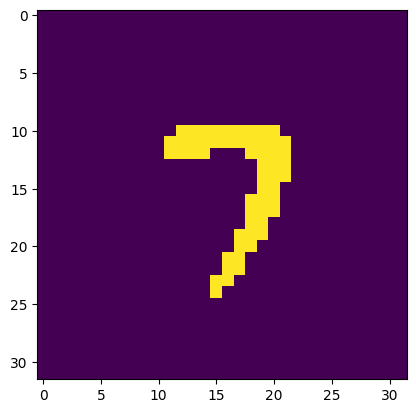

In [26]:
plt.imshow(images[-1].cpu().numpy()[2,0])